# README
- [Start Here: A Gentle Introduction | Kaggle](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)
- [Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data)


# Introduction: Home Credit Default Risk Competition

## コンペの目的
- 過去のローン申請データを使用して、申請者がローンを返済できるかどうかを予測すること
- ラベルはバイナリ
    - 0: 期日通りに返済できる
    - 1: 返済が難しい

# Data
- dataは7つある
- このKernelでは `application_train.csv` と `application_test.csv`しか見てないので、それ以外のdataは読み飛ばす
- ER図も取りあえず、スルー



## Metric
- ROC_AUCを使う

## Imports

In [1]:
import gc
import os
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.testing import assert_array_equal
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import (Imputer, LabelEncoder, MinMaxScaler,
                                   PolynomialFeatures)

warnings.filterwarnings('ignore')

/Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Read in Data

In [2]:
# training data
app_train = pd.read_csv('input/application_train.csv')

print(app_train.shape)
app_train.head()

(307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [3]:
# Test data
app_test = pd.read_csv('input/application_test.csv')

print(app_test.shape)
app_test.head()

(48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

# Exploratory Data Analysis

## Examine the Distribution of the Target Column

In [4]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

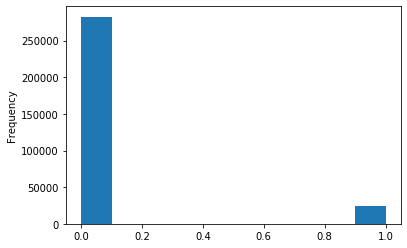

In [5]:
app_train['TARGET'].astype(int).plot.hist()

- クラスバランスが不均衡
    - 0(期日通りに返済した)が圧倒的に多い
- この不均衡をうまく取り入れた機械学習モデルをつくるのが肝要だね

## Examine Missing Values¶
- MEMO
    - カラムが多いので、 .info() じゃあ表示しきれない
    - 欠損情報だけをまとめたDFを作っておくと再利用しやすい


In [6]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns



In [7]:
missing_values = missing_values_table(app_train)

missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

- これらの欠損をいかに補完するかが勝負の1つ
- だけど、今回は、欠損の補完が不要なXGBoostを使う
    - 要チェック: XGBoostは欠損をどう扱っているのか？
- あるいは、欠損の割合が大きいカラムを除去するのも1つの手        
    - しかし、どのカラムがモデルに役立つのかを事前に知るのは不可能
    - なので、今回は全てのカラムを保持する

## Column Types¶


In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

- まずは、カテゴリ変数をみていく
    - カテゴリ変数の詳細ではなく、それぞれのカラムは何個のカテゴリがあるか？

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
# MEMO: ユニークな値をみるならこう書く
app_train['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [11]:
# MEMO: ユニークな値の「個数」をみるなら nunique()
app_train['NAME_CONTRACT_TYPE'].nunique()

2

- 大半のカテゴリ変数は、少ないカテゴリ数
- めっちゃカテゴリ数が多いカラムもある


## Encoding Categorical Variables¶
- 多くの機械学習モデルではカテゴリ変数を直接扱えない
- 作戦は2つある


### 1. Labelencoding
- それぞれの値に、数値を割り当てる
- 問題点
    - 任意の順序関係が生まれてしまう
    - 複数の実装者が別々の数値を割り当てるとまずい
    - 2値であれば、LabelEncodingは問題ないが、2つを超える場合はOne-hot-encodingが安全

### 2. One-hot encoding
- カラムをつくるいつものやつ
- 問題点
    - (Kernel筆者によれば)カテゴリの次元がおおいときに問題だとさ
    - そういうときは次元削減するってさ

### まとめ
- LabelEncodingとOne-hot-encodingの相対的なメリットは議論がある
- おすすめ → [scikit learn - When to use One Hot Encoding vs LabelEncoder vs DictVectorizor? - Data Science Stack Exchange](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor)


### Label Encoding and One-Hot Encoding¶


In [12]:
# ユニーク数が2つ以下のカテゴリ変数だけを
# ちなみに、ユニークが1つのカテゴリ変数は存在しない
le = LabelEncoder()
le_count = 0


for col in app_train.columns:
    if app_train[col].dtype == 'object':
        unique_count = len(app_train[col].unique())
        if 0 < unique_count <= 2:
            le.fit(app_train[col])

            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            le_count += 1

print(f'{le_count} columns were lebal-encoded')

3 columns were lebal-encoded


In [13]:
# MEMO: LabelEncoderの使い方
label_encoder = LabelEncoder()
label_encoder.fit([1, 2, 2, 6])

print(label_encoder.classes_)

print(label_encoder.transform([1, 1, 2, 6]))

print(label_encoder.inverse_transform([0, 0, 1, 2]))


[1 2 6]
[0 0 1 2]
[1 1 2 6]


In [14]:
# 残りのカテゴリ変数は、One-hot-encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print(f'Train Features shape {app_train.shape}')
print(f'Test Features shape {app_test.shape}')

Train Features shape (307511, 243)
Test Features shape (48744, 239)


### Aligning Training and Testing Data¶
- TrainingDataとTestDataの列数を揃える(Trainの方が多くなっている)
    - ずれる原因はOne-hot-encodingで、片側にしかない値がある場合
    - LabelEncodingでは列数はずれない
- TestDataに含まれていないTrainingDataの列を削るらしい
    - Trainingにしかない情報はすてることになる

In [15]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test,
                                      join='inner', # inner-joinなので、共通しないカラムは落ちる
                                      axis=1)


app_train['TARGET'] = train_labels

print(f'Train Features shape {app_train.shape}')
print(f'Test Features shape {app_test.shape}')

# 'TARGET' 以外のカラムが完全に一致している
assert_array_equal(app_train.drop('TARGET', axis=1).columns, 
                   app_test.columns)

Train Features shape (307511, 240)
Test Features shape (48744, 239)


In [16]:
# MEMO: pandas.df.align
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.align.html
df1 = pd.DataFrame()
df1['a'] = [1, 2]


df2 = pd.DataFrame()
df2['a'] = [1, 2]
df2['b'] = [3, 4]

df1.align(df2, join='inner', axis=1)
df1.align(df2, join='outer', axis=1)

df2.align(df1, join='inner', axis=1)
df2.align(df1, join='outer', axis=1)


(   a  b
 0  1  3
 1  2  4,    a   b
 0  1 NaN
 1  2 NaN)

## Back to Exploratory Data Analysis¶


### Anomalies¶
- 'DAYS_BIRTH' は 「現在の融資申請に関連して記録されている」ので「負の値を取る。
- これを年数で見るには、 -1 をかけて、 1年の日数で割る


In [17]:
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [18]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

- 合理的な感じがするね
- DAYS_EMPLOYMENTはどうかな？

In [19]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

- おかしいね！
    - 最大値を年数に直すと、1000年超え！

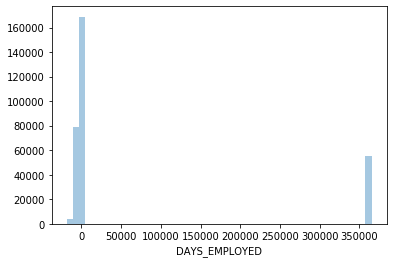

In [20]:
# 365243日が 5万件くらいある！
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False)

- just out of curiosity(好奇心で)、寄り道
    - DAY_EMPLOYEDが異常値のやつで層別にみていく
    - デフォルト率をみてみる

In [21]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] !=365243]


print(f'The anomalies default rate     {anom["TARGET"].mean():.2f}')
print(f'The non-anomalies default rate {non_anom["TARGET"].mean():.2f}')

The anomalies default rate     0.05
The non-anomalies default rate 0.09


- 4%も乖離があるよ！
- 異常値のほうがデフォルト率が低い！

この異常値は重要に思える(4%も乖離がある)ので、モデルに入れようと思う。

- 値が異常値かどうかを表現するBooleanカラムをつくる
- もとのカラムの異常値はNaNに置き換えて、異常値抜きの分布をみる





Text(0.5, 0, 'Days Employed')

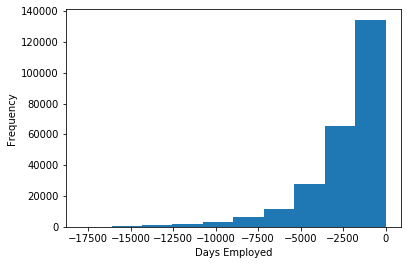

In [22]:
# シンプルに書けるね
app_train['DAYS_EMPLOYED_ANOM'] = (app_train["DAYS_EMPLOYED"] == 365243)

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# sns.distplot(app_train['DAYS_EMPLOYED']) # ValueError: cannot convert float NaN to integer
# sns.distplot(app_train['DAYS_EMPLOYED'].dropna()) # Nanを落とせばOK

# df.plot.hist()の場合はこう書く
app_train['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employed')

> The distribution looks to be much more in line with what we would expect

- どのあたりが「期待通り」なのか？
- マイナスが大きいほど就業日数が多いとすると、まあ確かにそうかな〜というところ


> The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

- 他の「Days_hoge」カラムは異常値がないという前提で進めるよ

There are 9274 anomalies in the test data out of 48744 entries


Text(0.5, 0, 'Days Employed')

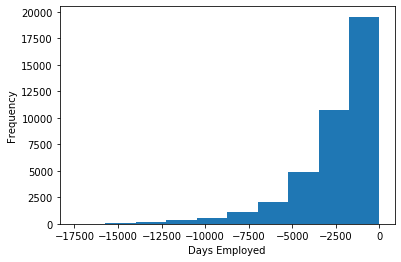

In [23]:
# TestDataにも同じ処理をしておく
# MEMO: なるほど。たしかにTrainingDataに処理した直後にまとめてやるほうが賢いかもね。

app_test['DAYS_EMPLOYED_ANOM'] = (app_test["DAYS_EMPLOYED"] == 365243)

app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


anom_entries_count = app_test["DAYS_EMPLOYED_ANOM"].sum()
print(f'There are {anom_entries_count} anomalies in the test data out of {len(app_test)} entries' % ())
# MEMO: ついでに分布もみてみた(これくらいはみてもOK?)
# 分布もだいたい同じ感じだ
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employed')

### Correlations¶
- dataを理解するためには相関関係を探すのはいいことだよ
    - あくまで関連性だけだから注意な
- ピアソンの相関係数をみていくよ

In [24]:
# TARGETと全カラムの相関を計算しているから結構な時間がかかる(40s)
correlations = app_train.corr()['TARGET'].sort_values()

# 相関が大きいものをいくつか見る
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

- DAYS_BIRTHは最も高い相関を見せている(0.078239)

> Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). 

ドキュメントを見ると、DAYS_BIRTHは、負の日数での融資時のクライアントの年齢。(たぶんこの翻訳がただしいと思う)

> The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0).


相関は「正」だけど、DAY_BIRTHは負の値なので、実際は「負の相関」。
- つまり、年をとるほど、TARGETの値がマイナスに向かう
    - 年齢が高いほど、ローンがデフォルトになる可能性が低くなる という意味だね

> That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

上記の解釈だと、ややこしくなるから、絶対値に変換して解釈しやすくしよう作戦




### Effect of Age on Repayment


In [25]:
app_train['DAYS_BIRTH'] = app_train['DAYS_BIRTH'].abs()

app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

- 負の相関だった
    - つまり、顧客が年をとるほど、返済する傾向がある(デフォルトしにくくなる)
    
> Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable. 

つづいて、年齢の値をみていくよ


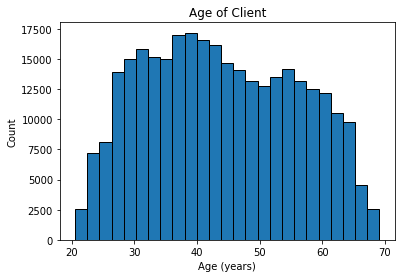

In [26]:
plt.hist(app_train['DAYS_BIRTH'] / 365, # 日齢->年齢
         edgecolor='k',
         bins=25)

plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count');

- 異常値はなさそう
- 異常値がないこと以外の情報はパット見では得られない感じ

TARGETに対する年齢の影響を視覚化するために、KDEを使う。

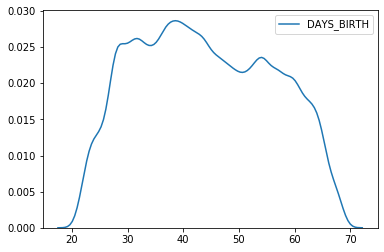

In [27]:
sns.kdeplot(app_train['DAYS_BIRTH'] / 365)

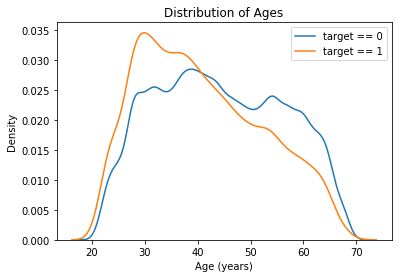

In [28]:
# MEMO:
# app_train[app_train['TARGET']==0]['DAYS_BIRTH'] / 365 よりも .locの方がわかりやすいかも?
# sns.kdeplot(app_train.loc[app_train['TARGET'] == 0,'DAYS_BIRTH'] / 365,
#             label='target == 0')

# まあでも、変数を作った方が見やすいと思う
app_train_target0 = app_train[app_train['TARGET'] == 0]
app_train_target1 = app_train[app_train['TARGET'] == 1]


# MEMO: kdeplotだけの方が見やすいね(Histgramは余計だ
# MEMO: 層化して分布を重ねるのは基本だし、覚えていこう
sns.kdeplot(app_train_target0['DAYS_BIRTH'] / 365,
            label='target == 0')

sns.kdeplot(app_train_target1['DAYS_BIRTH'] / 365,
            label='target == 1')


plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages');

- target1 は若い人に尖りがある(==デフォルトしやすい)
- 相関係数 -0.07 は有意な相関じゃないけど、きっと機械学習モデルでは有効な変数になりそう


つづいて、「別の方法」で、同じく年齢をみていくよ

- 年齢を5年ごとに区分していく
- 各区分において、TARGETの平均を見る == デフォルト率がわかる
    - 「TARGETは 0か1 なので、割合になる」ってのは頻出だよね

In [29]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data.head()

TARGET  DAYS_BIRTH  YEARS_BIRTH
0       1        9461    25.920548
1       0       16765    45.931507
2       0       19046    52.180822
3       0       19005    52.068493
4       0       19932    54.608219

In [30]:
# 5年毎のbinにカットしていく
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],
                                  bins=np.linspace(20, 70, num=11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [31]:
age_groups = age_data.groupby('YEARS_BINNED').mean()

age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

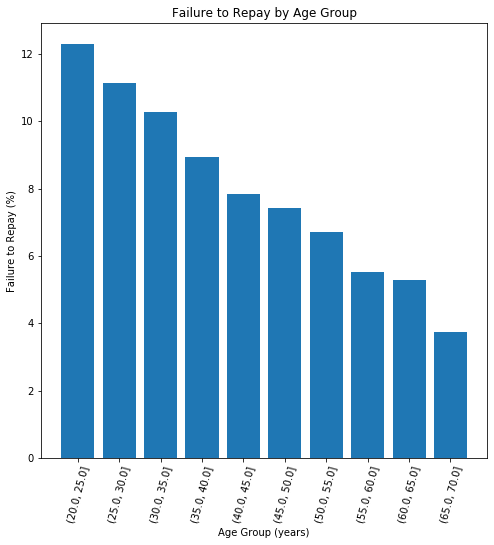

In [32]:
plt.figure(figsize=(8, 8))


plt.bar(age_groups.index.astype(str),  # pd.cutはCategoricalIndexになるStringに変換
        100 * age_groups['TARGET'])

# snsだと全てのBarに色がつくので、今回は不要かも
# sns.barplot(age_groups.index.astype(str),
#         100 * age_groups['TARGET'])

plt.xticks(rotation=75)  # これは使える
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

- 明らかなトレンドがある
    - 若いほうがデフォルトしやすい
        - 3つのグループでは10%超え
    - そして、KDEよりも見やすいと思った
- コレは使える変数
- 注意
    - 「若い人に融資しないほうが良い」という意味にはならない

### Exterior Sources¶
> According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.
JAPANESE

資料によると、これらの機能は「外部データソースからの正規化スコア」を表しています。これが正確に何を意味するのか私にはわかりませんが、それは多数のデータソースを使って作られた累積的な種類の信用格付けかもしれません。


In [33]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

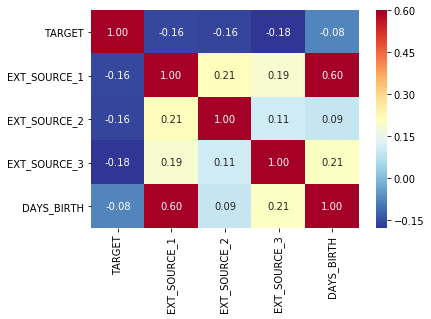

In [34]:
# heatmatpの方がみやすいね
sns.heatmap(ext_data_corrs,
            annot=True,
            cmap=plt.cm.RdYlBu_r,
            vmax=0.6,
            fmt='.2f')

- 3つのEXT_SOURCEは全てTARGETと負の相関がある
    - EXT_SOURCEの値が大きほど、返済可能性が高い傾向
- EXT_SOURCE1 と DAY_BIRTH は高い相関がある(0.60)
    - このEXT_SOURCE1というスコアは、、顧客の年齢が要因の1つであるかもしれん    

In [35]:
# スコアの取る範囲は大体 0 〜 1近く
ext_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].describe()

EXT_SOURCE_1  EXT_SOURCE_2   EXT_SOURCE_3
count  134133.000000  3.068510e+05  246546.000000
mean        0.502130  5.143927e-01       0.510853
std         0.211062  1.910602e-01       0.194844
min         0.014568  8.173617e-08       0.000527
25%         0.334007  3.924574e-01       0.370650
50%         0.505998  5.659614e-01       0.535276
75%         0.675053  6.636171e-01       0.669057
max         0.962693  8.549997e-01       0.896010

次に、TARGETで層化して、各スコアの分布をみる

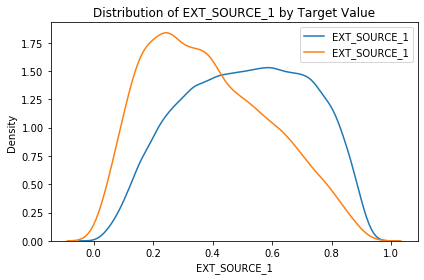

In [36]:
ext_data_target0 = ext_data[ext_data['TARGET'] == 0]
ext_data_target1 = ext_data[ext_data['TARGET'] == 1]

source = 'EXT_SOURCE_1'
sns.kdeplot(ext_data_target0[source].dropna())
sns.kdeplot(ext_data_target1[source].dropna())

# Label the plots
plt.title(f'Distribution of {source} by Target Value')
plt.xlabel(source)
plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

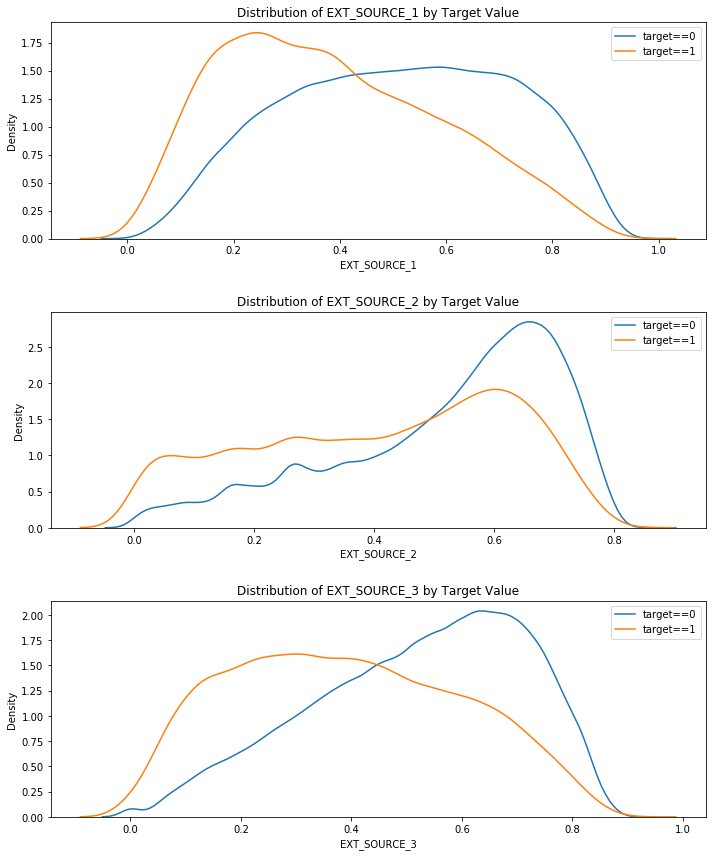

In [37]:
ext_data_target0 = ext_data[ext_data['TARGET'] == 0]
ext_data_target1 = ext_data[ext_data['TARGET'] == 1]


plt.figure(figsize=(10, 12))

for idx, source_col in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    plt.subplot(3, 1, idx + 1)

    # snsならこう書く
    # sns.kdeplot(ext_data_target0[source_col].dropna(), label='target==0')
    # sns.kdeplot(ext_data_target1[source_col].dropna(), label='target==1')

    sns.kdeplot(ext_data.loc[ext_data['TARGET'] == 0, source_col].dropna(), label='target==0')
    sns.kdeplot(ext_data.loc[ext_data['TARGET'] == 1, source_col].dropna(), label='target==1')

    # Label the plots
    plt.title(f'Distribution of {source_col} by Target Value')
    plt.xlabel(source_col)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

- EXT_SOURCE3は大きな傾向の違いを出している！
    - この変数は、ローン返済する可能性と、ある程度の関係があることがわかるね
- そこまで関係は強くない(実際、相関は弱い)
- でも、この3つのスコアは、申込者が予定通り返済するかを予測する機械学習モデルには依然として有用

## Pairs Plot¶


In [38]:
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

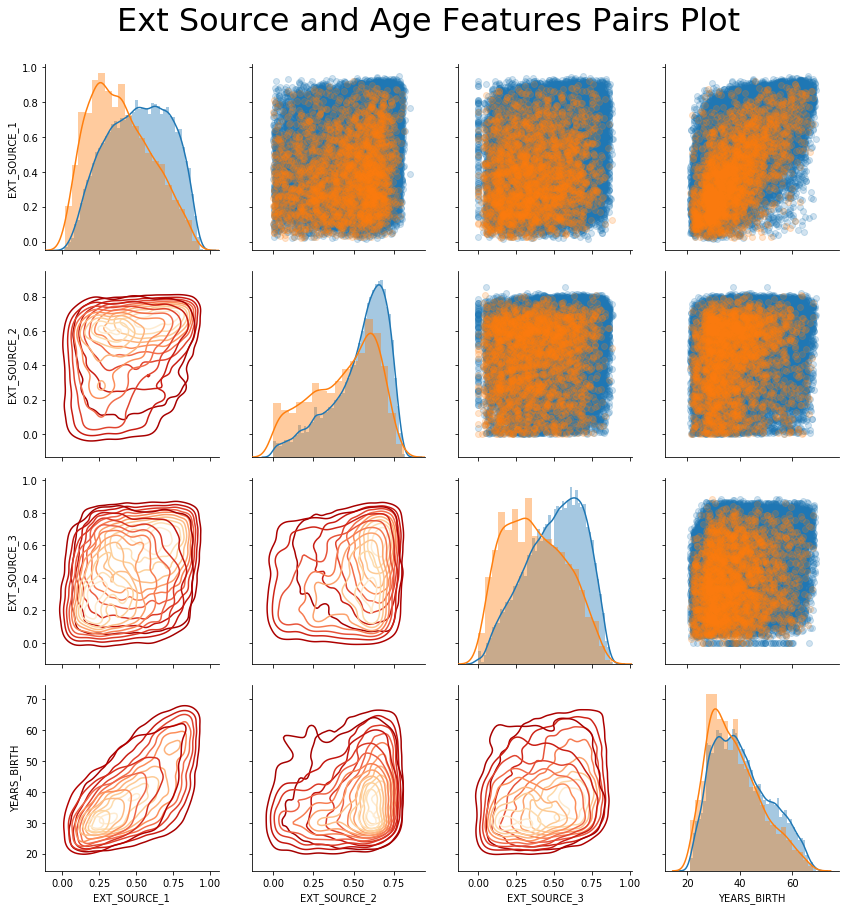

In [39]:
# CAUTION: 結構時間かかる(30s)
# MEMO: sns.PairGridの使い方
# https://code-graffiti.com/seaborn-grid-in-python/

usecols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH']

# PairのGridを用意する
grid = sns.PairGrid(data=plot_data,
                    size=3,
                    diag_sharey=False,  # yの値をshareするかフラグ
                    hue='TARGET',
                    vars=usecols  # 使用するカラム(デフォルトだと全部使う)
                    )


# 上三角成分には、散布図を描く
grid.map_upper(plt.scatter, alpha=0.2)

# 対角成分はkdeplot
grid.map_diag(sns.distplot)

# 下三角成分には等高線的なグラフ？？？
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

- 情報量がすごいなあ
- EXT_SOURCE1とYEARS_BIRTH(右上)はゆるやかな線形性があるように見える
    - つまり、EXT_SOURCE1は年齢を考慮した変数だということを示唆している

おわり